In [1]:
#Importing Libraries or Packages that are needed throughout the Program 
import numpy as np 
import pandas as pd 
import xgboost as  xgb 
import random 
import datetime as dt 
import gc

# Load the Datasets #

DirBase = "/Volumes/wms_ssd/Qualifying Exam/"

# We need to load the datasets that will be needed to train our machine learning algorithms, handle our data and 
# make predictions. Note that these datasets are the ones that are already provided once you enter the competition
# by accepting terms and conditions

train = pd.read_csv(DirBase+'Input/data.csv')
properties_2016_df = pd.read_csv(DirBase+'Input/properties_2016_mod.csv')
properties_2017_df = pd.read_csv(DirBase+'Input/properties_2017_mod.csv')
test = pd.read_csv(DirBase+'Output/sample_submission.csv') 
test = test.rename(columns={'ParcelId': 'parcelid'}) # To make it easier for merging datasets on same column_id later
output = test.copy()

# Analyse the Dimensions of our Datasets.

print("Training Size:" + str(train.shape))
print("Sample Size:" + str(test.shape))


Training Size:(167888, 87)
Sample Size:(2985217, 7)


In [2]:

# Type Converting the DataSet 

# The processing of some of the algorithms can be made quick if data representation is made in int/float32 instead
# of int/float64. Therefore, in order to make sure that all of our columns types are in float32, we are
# implementing the following lines of code #

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:        
        train[c] = train[c].astype(np.float32)
    if dtype == np.int64:
        train[c] = train[c].astype(np.int32)

for column in test.columns:
    if test[column].dtype == int:
        test[column] = test[column].astype(np.int32)
    if test[column].dtype == float:
        test[column] = test[column].astype(np.float32)

df_test_2016 = test.merge(properties_2016_df, how='left', on='parcelid')
df_test_2017 = test.merge(properties_2017_df, how='left', on='parcelid')

### Remove previous variables to keep some memory
del properties_2016_df, properties_2017_df

print('Memory usage reduction...')
train[['latitude', 'longitude']] /= 1e6
df_test_2016[['latitude', 'longitude']] /= 1e6
df_test_2017[['latitude', 'longitude']] /= 1e6

train['censustractandblock'] /= 1e12
df_test_2016['censustractandblock'] /= 1e12
df_test_2017['censustractandblock'] /= 1e12


Memory usage reduction...


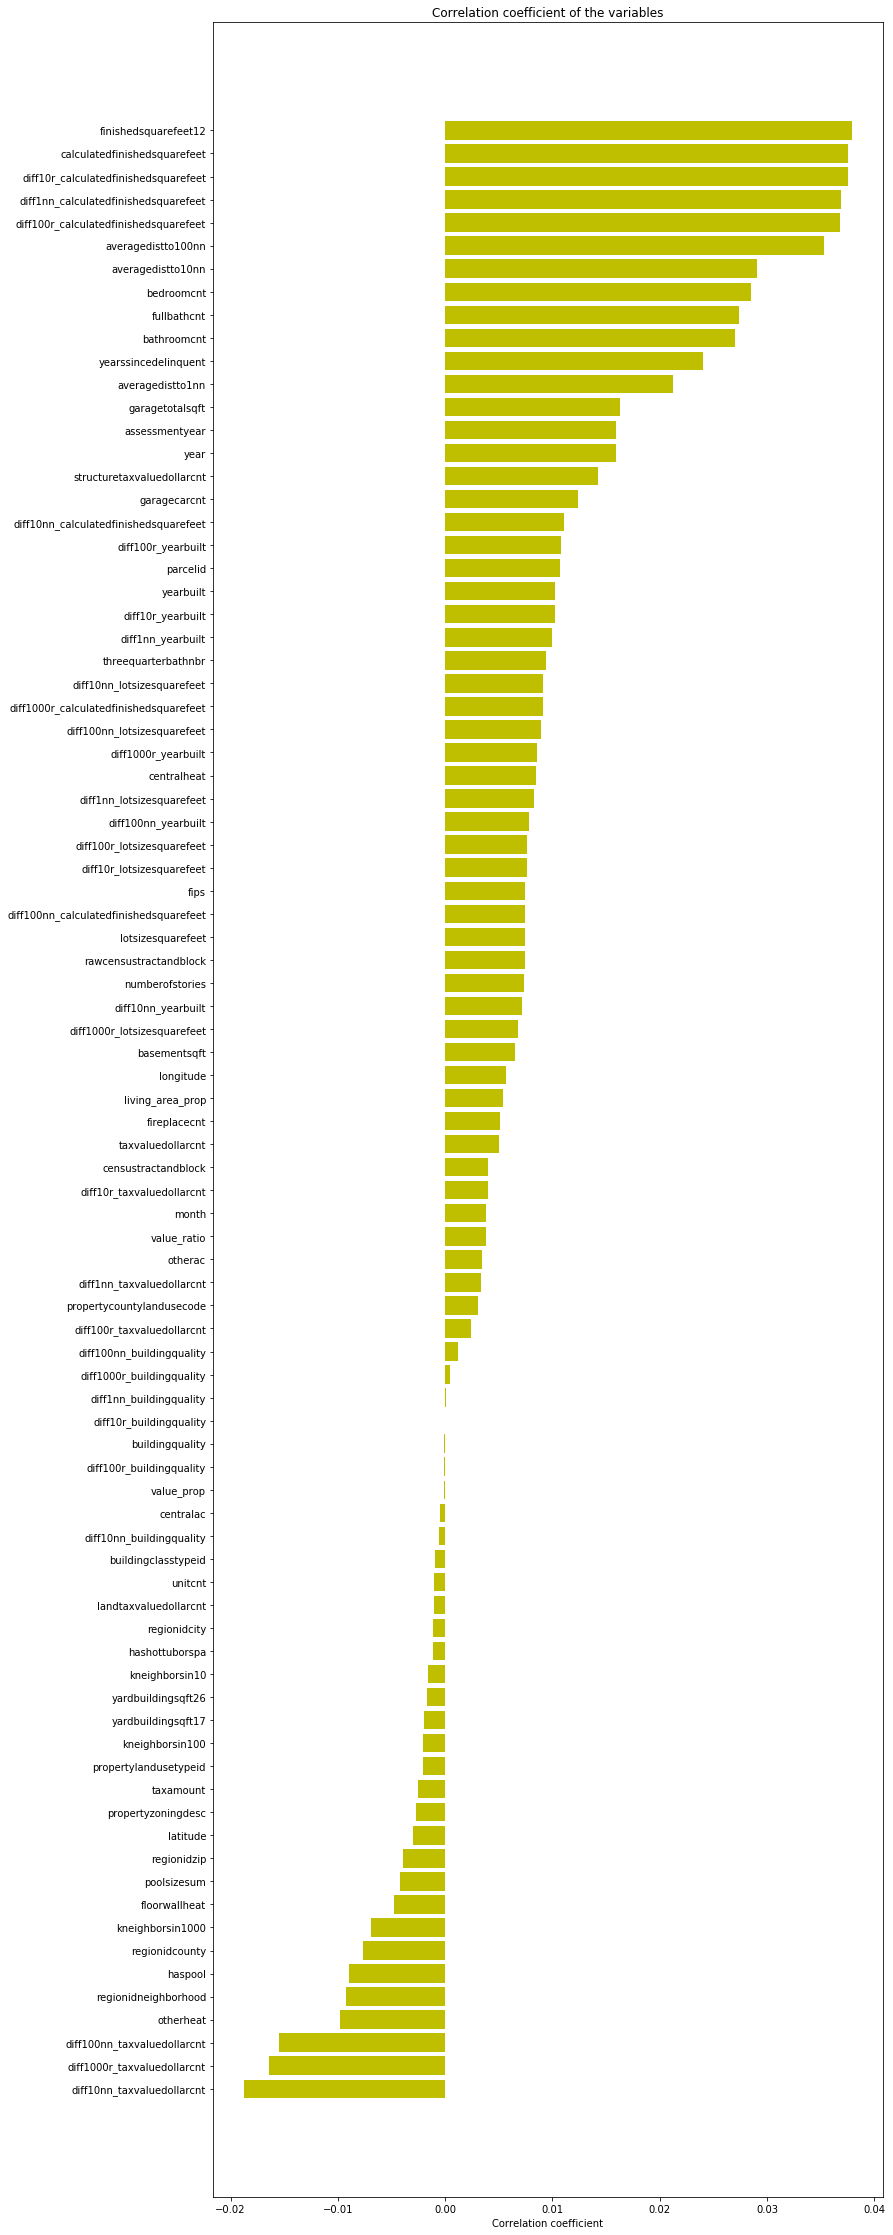

In [5]:
import matplotlib.pyplot as plt

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train.columns if col not in ['logerror'] if train[col].dtype!='object']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [6]:
corr_df_sel_1 = corr_df.loc[(corr_df['corr_values']<0.01) & (corr_df['corr_values'] > -0.01)]
corr_df_sel_1

,col_labels,corr_values
44,otherheat,-0.009794
25,regionidneighborhood,-0.009249
46,haspool,-0.008924
24,regionidcounty,-0.007654
55,kneighborsin1000,-0.006886
43,floorwallheat,-0.004794
18,poolsizesum,-0.004183
26,regionidzip,-0.003959
15,latitude,-0.002995
21,propertyzoningdesc,-0.002679


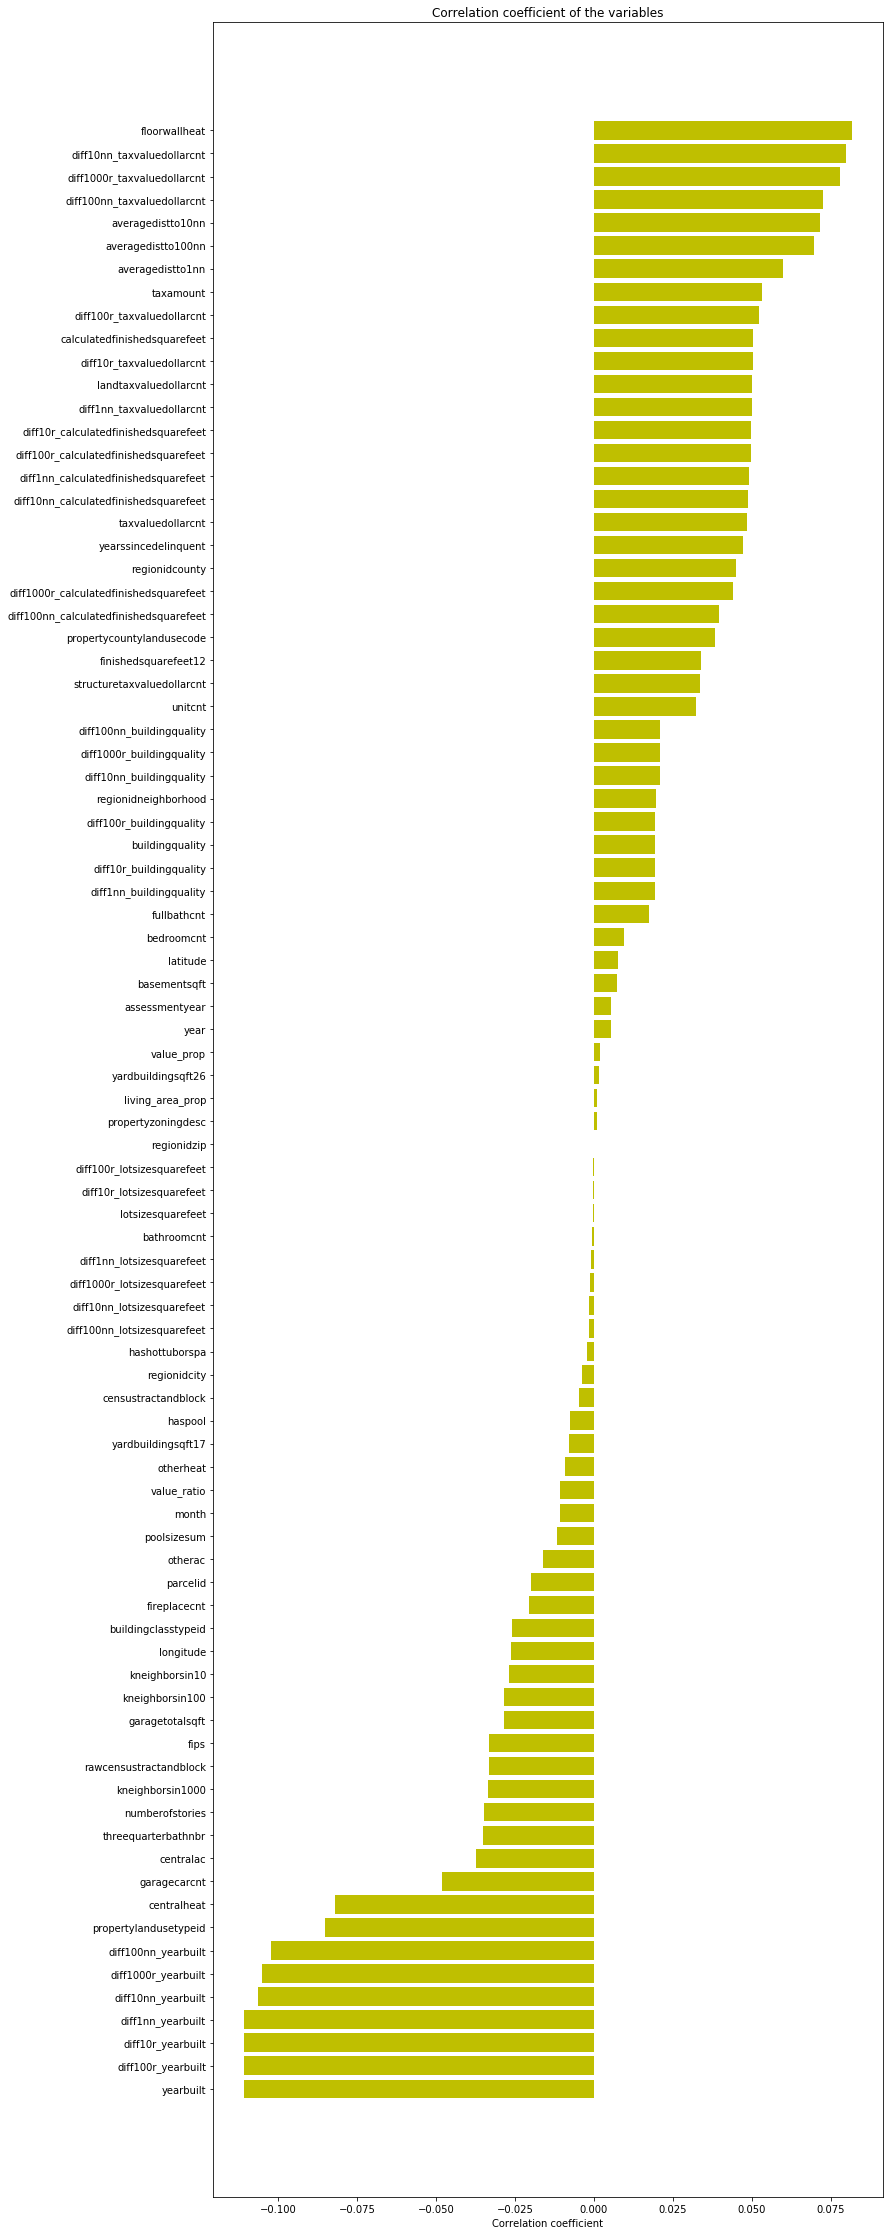

In [7]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train.columns if col not in ['logerror'] if train[col].dtype!='object']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, abs(train.logerror.values))[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [8]:
corr_df_sel_2 = corr_df.loc[(corr_df['corr_values']<0.05) & (corr_df['corr_values'] > -0.05)]
corr_df_sel_2

,col_labels,corr_values
12,garagecarcnt,-0.048093
40,centralac,-0.037437
27,threequarterbathnbr,-0.035074
32,numberofstories,-0.034902
55,kneighborsin1000,-0.033609
22,rawcensustractandblock,-0.033220
9,fips,-0.033074
13,garagetotalsqft,-0.028570
54,kneighborsin100,-0.028363
53,kneighborsin10,-0.027002


In [11]:
both = list(set(corr_df_sel_1['col_labels']) & set(corr_df_sel_2['col_labels']))
both

['value_prop',
 'diff1000r_lotsizesquarefeet',
 'diff10nn_lotsizesquarefeet',
 'poolsizesum',
 'value_ratio',
 'diff1nn_buildingquality',
 'diff10nn_buildingquality',
 'otherac',
 'diff100r_buildingquality',
 'fireplacecnt',
 'taxvaluedollarcnt',
 'kneighborsin10',
 'hashottuborspa',
 'diff1000r_calculatedfinishedsquarefeet',
 'living_area_prop',
 'yardbuildingsqft26',
 'numberofstories',
 'threequarterbathnbr',
 'diff100nn_buildingquality',
 'latitude',
 'diff100r_lotsizesquarefeet',
 'fips',
 'diff100nn_calculatedfinishedsquarefeet',
 'buildingclasstypeid',
 'rawcensustractandblock',
 'month',
 'diff1nn_lotsizesquarefeet',
 'diff100nn_lotsizesquarefeet',
 'otherheat',
 'propertycountylandusecode',
 'basementsqft',
 'diff1000r_buildingquality',
 'diff1nn_taxvaluedollarcnt',
 'diff10r_buildingquality',
 'propertyzoningdesc',
 'lotsizesquarefeet',
 'unitcnt',
 'kneighborsin1000',
 'haspool',
 'censustractandblock',
 'longitude',
 'centralac',
 'yardbuildingsqft17',
 'regionidzip',
 'reg

In [16]:
### Rearranging the DataSets ###

# We will now drop the features that serve no useful purpose. We will also split our data and divide it into the
# representation to make it clear which features are to be treated as determinants in predicting the outcome for
# our target feature. Make sure to include the same features in the test set as were included in the training set

x_train = train.drop(both + ['parcelid', 'logerror', 'propertyzoningdesc', 
                         'propertycountylandusecode', 'month', 'year'], axis=1)

both.pop(both.index('month'))
df_test_2016 = df_test_2016.drop(both + ['parcelid', 'propertyzoningdesc',
                       'propertycountylandusecode', '201610', '201611', 
                       '201612', '201710', '201711', '201712'], axis = 1) 

df_test_2017 = df_test_2017.drop(both + ['parcelid', 'propertyzoningdesc',
                       'propertycountylandusecode', '201610', '201611', 
                       '201612', '201710', '201711', '201712'], axis = 1) 

x_train = x_train.values
y_train = train['logerror'].values



In [20]:
x_train.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [26]:
### Cross Validation ###

# We are dividing our datasets into the training and validation sets so that we could monitor and the test the
# progress of our machine learning algorithm. This would let us know when our model might be over or under fitting
# on the dataset that we have employed.

from sklearn.model_selection import train_test_split

X = x_train
y = y_train 

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=42)

# Implement the Xgboost #

# We can now select the parameters for Xgboost and monitor the progress of results on our validation set. The
# explanation of the xgboost parameters and what they do can be found on the following link
# http://xgboost.readthedocs.io/en/latest/parameter.html 

dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dvalid = xgb.DMatrix(Xvalid, label=yvalid)


# Best: -0.069305 using {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 5, 'learning_rate': 0.5, 
# 'gamma': 10, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2}

# Best: -0.069555 using {'subsample': 0.4, 'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 3, 'learning_rate': 0.4,
# 'gamma': 1, 'colsample_bytree': 0.1, 'colsample_bylevel': 0.3}

# Best: -0.069379 using {'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha': 0, 'max_depth': 6, 'learning_rate': 0.1,
# 'gamma': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.3}

# Try different parameters! 
xgb_params = {'min_child_weight': 5, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'mae', 
              'objective': 'reg:linear' , 'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha': 0, 'max_depth': 6, 
              'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.3} 

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model_xgb = xgb.train(xgb_params, dtrain, 1000, watchlist, early_stopping_rounds=100,
                  maximize=False, verbose_eval=10)


[0]	train-mae:0.448497	valid-mae:0.448143
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.177339	valid-mae:0.17727
[20]	train-mae:0.094582	valid-mae:0.094355
[30]	train-mae:0.074243	valid-mae:0.074139
[40]	train-mae:0.070098	valid-mae:0.070105
[50]	train-mae:0.069181	valid-mae:0.069289
[60]	train-mae:0.068881	valid-mae:0.069096
[70]	train-mae:0.06877	valid-mae:0.069081
[80]	train-mae:0.068704	valid-mae:0.069109
[90]	train-mae:0.068637	valid-mae:0.06914
[100]	train-mae:0.068556	valid-mae:0.069153
[110]	train-mae:0.068495	valid-mae:0.069181
[120]	train-mae:0.068458	valid-mae:0.069239
[130]	train-mae:0.068364	valid-mae:0.069236
[140]	train-mae:0.068317	valid-mae:0.069279
[150]	train-mae:0.06821	valid-mae:0.069301
[160]	train-mae:0.068165	valid-mae:0.069353
[170]	train-mae:0.068136	valid-mae:0.069398
Stopping. Best iteration:
[71]	train-mae:0.068757	valid-mae:0.069075



In [27]:
# Predicting the results #

# Let us now predict the target variable for our test dataset. All we have to do now is just fit the already
# trained model on the test set that we had made merging the sample file with properties dataset #

months = [10, 11, 12]
years = [2016, 2017]


for y in years:
    if y == 2016:
        x_test = df_test_2016
    else:
        x_test = df_test_2017

    print("PREDICTING " + str(y) + " ...")
    
    dtest = xgb.DMatrix(x_test.values)

    Predicted_test_xgb = model_xgb.predict(dtest)

    
    for m in months:        
        name = str(y) + str(m)
        output[name] = Predicted_test_xgb

print(output.head(50))
# Submitting the Results 
print('Preparing the csv file ...')
output.to_csv(DirBase+'xgb_predicted_results_mod11.csv', index=False, float_format='%.4f')
print("Finished writing the file")

PREDICTING 2016 ...
PREDICTING 2017 ...
    parcelid    201610    201611    201612    201710    201711    201712
0   10754147 -0.014113 -0.014113 -0.014113 -0.013406 -0.013406 -0.013406
1   10759547 -0.045195 -0.045195 -0.045195 -0.060757 -0.060757 -0.060757
2   10843547  0.038939  0.038939  0.038939 -0.054882 -0.054882 -0.054882
3   10859147  0.022210  0.022210  0.022210  0.037056  0.037056  0.037056
4   10879947 -0.036693 -0.036693 -0.036693 -0.090922 -0.090922 -0.090922
5   10898347  0.017757  0.017757  0.017757  0.035765  0.035765  0.035765
6   10933547 -0.010395 -0.010395 -0.010395 -0.006486 -0.006486 -0.006486
7   10940747 -0.162078 -0.162078 -0.162078 -0.139677 -0.139677 -0.139677
8   10954547 -0.023539 -0.023539 -0.023539  0.006176  0.006176  0.006176
9   10976347 -0.008565 -0.008565 -0.008565  0.012971  0.012971  0.012971
10  11073947  0.063593  0.063593  0.063593  0.088099  0.088099  0.088099
11  11114347  0.028934  0.028934  0.028934  0.072608  0.072608  0.072608
12  1111694

In [28]:
output.shape

(2985217, 7)

In [5]:
print(output.head(50))

    parcelid    201610    201611    201612    201710    201711    201712
0   10754147 -0.055875 -0.055875 -0.055875 -0.065116 -0.065116 -0.065116
1   10759547  0.028946  0.028946  0.028946  0.000703  0.000703  0.000703
2   10843547  0.023374  0.023374  0.023374  0.134059  0.134059  0.134059
3   10859147  0.009479  0.009479  0.009479 -0.015481 -0.015481 -0.015481
4   10879947  0.018441  0.018441  0.018441  0.018218  0.018218  0.018218
5   10898347  0.050160  0.050160  0.050160  0.031975  0.031975  0.031975
6   10933547 -0.004305 -0.004305 -0.004305 -0.003058 -0.003058 -0.003058
7   10940747 -0.062723 -0.062723 -0.062723 -0.061476 -0.061476 -0.061476
8   10954547 -0.057813 -0.057813 -0.057813 -0.049105 -0.049105 -0.049105
9   10976347 -0.060091 -0.060091 -0.060091 -0.057998 -0.057998 -0.057998
10  11073947  0.022292  0.022292  0.022292  0.023338  0.023338  0.023338
11  11114347 -0.027423 -0.027423 -0.027423 -0.013595 -0.013595 -0.013595
12  11116947  0.012339  0.012339  0.012339  0.01343